In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import mplcyberpunk
plt.style.use("cyberpunk")

In [ ]:
def tokenize(text):
    patterns = [
        (r'\b[a-zA-Z]+@[a-zA-Z]+\.[a-zA-Z]+\b', 'EMAIL'),
        (r'(?:\+7[-.\s]?)?\(?9\d{2}\)?[-.\s]?\d{3}[-.\s]?\d{2}[-.\s]?\d{2}|(?:8[-.\s]?)?\(?9\d{2}\)?\d{7}', 'PHONE'),
        (r'\b(?:Dr|Mr|Mrs|Ms|Prof)\.\s+[A-Z][a-zA-Z]*', 'ABBREVIATION'),
        (r'\b(?:Dr|Mr|Mrs|Ms|Prof|St)\.\s+[A-Z][a-zA-Z]*(?:\'[a-z]+)?', 'APPEAL_WITH_WORD'),
        (r'\$[\d,]+(?:\.\d{2})?|\d+\.\d{2}\$', 'CURRENCY'),
        (r'https?://[^\s<>"{}|\\^`\[\]]+', 'URL'),
        (r'^[a-zA-Z_]\w*\s*=\s*[\w\s()+\-*/^]+(?:\s*=\s*[\w\s()+\-*/^]+)*$', 'MATH'),
        (r'г\.\s+\w+[а-яё]*,\s+ул\.\s+\w+[а-яё]*(?:-\w+[а-яё]*)*,\s+д\.\s+\d+(?:,\s+кв\.\s+\d+)?', 'ADDRESS'),
        (r'[;:][-o]?[D\)\(PpFf3\[\]}{@\|\\\/]', 'EMOTICON')
    ]

    placeholders = {}
    counter = 0

    # заменяем совпадения на плейсхолдеры
    for pattern, tag in patterns:
        matches = re.findall(pattern, text, flags=re.IGNORECASE)
        for match in set(matches):
            ph = f"__{tag}_{counter}__"
            placeholders[ph] = match
            text = re.sub(re.escape(match), ph, text, count=1)
            counter += 1

    # сплит предложений
    parts = re.split(r'([.!?]+)', text)
    if len(parts) < 2:
        sentences = [text]
    else:
        sentences = ["".join(x) for x in zip(parts[0::2], parts[1::2])]
        if len(parts) % 2 != 0:
            sentences.append(parts[-1])

    # токенизация
    all_sentences = []
    for sent in sentences:
        tokens = re.findall(r"\w+(?:'\w+)?|[^\w\s]", sent)
        out = []
        for t in tokens:
            if t in placeholders:
                out.append(placeholders[t])
            else:
                out.append(t)
        all_sentences.append(out)

    return all_sentences

In [ ]:
def load_csv_texts(train_csv="../assets/annotated-corpus/train.csv", test_csv="../assets/annotated-corpus/test.csv"):
    train = pd.read_csv(train_csv, header=None, names=["label", "title", "text"])
    test = pd.read_csv(test_csv, header=None, names=["label", "title", "text"])

    texts = train["text"].fillna("").tolist() + test["text"].fillna("").tolist()
    return texts, train, test

In [ ]:
def prepare_corpus(texts):
    corpus = []
    for t in tqdm(texts, desc="tokenizing"):
        sents = tokenize(t)
        for sent in sents:
            clean = []
            for w in sent:
                # если заглушка, то оставляем
                if isinstance(w, str) and w.startswith("__") and w.endswith("__"):
                    clean.append(w)
                else:
                    lw = str(w).lower()
                    if re.search("[a-zA-Z]", lw):
                        clean.append(lw)
            if clean:
                corpus.append(clean)
    return corpus

In [ ]:
def train_w2v(corpus, vector_size=200, window=5, min_count=2, sg=1, workers=4, epochs=10):
    model = Word2Vec(sentences=corpus, 
                     vector_size=vector_size, 
                     window=window,
                     min_count=min_count, 
                     sg=sg, 
                     workers=workers)
    model.train(corpus, 
                total_examples=len(corpus), 
                epochs=epochs)
    return model

In [ ]:
def cosine_distances(model, examples):
    for target, similar, same_domain, different in examples:
        print()
        print("=" * 50)
        print(f"Токен: {target}")
        print("=" * 50)

        if target not in model.wv:
            print("  → отсутствует в модели")
            continue

        tvec = model.wv[target].reshape(1, -1)
        groups = [
            ("Похожие", similar),
            ("Та же область", same_domain),
            ("Разные", different)
        ]

        for name, tokens in groups:
            print(f"\n{name}:")
            print("-" * 35)

            rows = []
            # вычисляем косинусное расстояние до каждого токена
            for tok in tokens:
                if tok in model.wv:
                    vec = model.wv[tok].reshape(1, -1)
                    cos_sim = float(cosine_similarity(tvec, vec)[0][0])
                    dist = 1.0 - cos_sim
                    rows.append((tok, dist))
                else:
                    rows.append((tok, None))

            # сортируем сначала близкие, потом отсутствующие
            rows.sort(key=lambda x: (x[1] is None, x[1] or 0))

            # выводим результаты
            for tok, dist in rows:
                if dist is None:
                    print(f"  {tok:20} → отсутствует")
                else:
                    print(f"  {tok:20} → {dist:.4f}")

In [ ]:
def eval_hyperparams(corpus, examples, grid):
    results = []
    for params in grid:
        print("train with", params)
        model = train_w2v(corpus, **params)
        sim_dists = []
        diff_dists = []
        for target, similar, same_domain, different in examples:
            if target not in model.wv:
                continue
            # вектор целевого токена
            tvec = model.wv[target].reshape(1, -1)
            # собираем расстояния до похожих токенов
            for tok in similar:
                if tok in model.wv:
                    v = model.wv[tok].reshape(1, -1)
                    sim_dists.append(1 - float(cosine_similarity(tvec, v)[0][0]))
            # собираем расстояния до разных токенов
            for tok in different:
                if tok in model.wv:
                    v = model.wv[tok].reshape(1, -1)
                    diff_dists.append(1 - float(cosine_similarity(tvec, v)[0][0]))
        # считаем средние расстояния
        sim_mean = np.mean(sim_dists) if sim_dists else float("nan")
        diff_mean = np.mean(diff_dists) if diff_dists else float("nan")

        results.append((params, sim_mean, diff_mean))
        print("  mean(sim)=", sim_mean, " mean(diff)=", diff_mean)
    return results

In [ ]:
def build_tfidf_from_corpus(corpus):
    """считаем веса для слов"""
    # объединяем токены каждого предложения в одну строку
    docs_joined = [" ".join(sent) for sent in corpus]
    vect = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
    vect.fit(docs_joined)

    idf = {}
    for tok, idx in vect.vocabulary_.items():
        idf[tok] = float(vect.idf_[idx])
    return vect, idf

In [ ]:
def sent_embedding_avg(model, tokens):
    """превращаем предложения в эмбеддинг, усредняя векторы некоторых слов"""
    # собираем вектора только для токенов, которые есть в модели
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    # если векторов нет, возвращаем нулевой вектор
    if not vecs:
        return np.zeros(model.vector_size, dtype=float)
    # возвращаем усредненный вектор
    return np.mean(vecs, axis=0)

In [ ]:
def sent_embedding_tfidf(model, tokens, idf_map, default_idf=1.0):
    """превращаем предложения в эмбеддинг, с помощью tf-idf"""
    vecs = []
    weights = []
    for t in tokens:
        if t in model.wv:
            # получаем idf-вес токена
            w = idf_map.get(t, default_idf)
            # умножаем вектор токена на его вес
            vecs.append(model.wv[t] * w)
            # сохраняем вес
            weights.append(w)
    # если нет подходящих токенов, возвращаем нулевой вектор
    if not vecs:
        return np.zeros(model.vector_size, dtype=float)
    # возвращаем нормализованное средневзвешенное
    return np.sum(vecs, axis=0) / (sum(weights) if sum(weights) != 0 else 1.0)

In [ ]:
def doc_embedding_from_sentences(model, sentences, method="avg", idf_map=None):
    """получаем эмбеддинг"""
    sent_embs = []
    for s in sentences:
        if method == "avg":
            # усредненный эмбеддинг
            sent_embs.append(sent_embedding_avg(model, s))
        elif method == "tfidf" and idf_map is not None:
            # взвешенный по tf-idf эмбеддинг
            sent_embs.append(sent_embedding_tfidf(model, s, idf_map))
        else:
            sent_embs.append(sent_embedding_avg(model, s))
    if not sent_embs:
        return np.zeros(model.vector_size, dtype=float)
    return np.mean(sent_embs, axis=0)

In [ ]:
def load_annotated_docs(base_dir="./assets/annotated-corpus/test"):
    docs = {}
    base = Path(base_dir)

    for class_dir in sorted(base.iterdir()):
        if not class_dir.is_dir():
            continue
        for file in sorted(class_dir.iterdir()):
            if file.suffix.lower() != ".tsv":
                continue
            doc_id = file.stem
            sentences = []
            cur = []
            with open(file, "r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        if cur:
                            sentences.append(cur)
                            cur = []
                        continue
                    parts = line.split("\t")
                    token = parts[0].lower() if parts else ""
                    if token:
                        cur.append(token)
                if cur:
                    sentences.append(cur)
            docs[doc_id] = sentences
    return docs

In [ ]:
def save_embeddings_tsv(model, docs_dict, out_file="embeddings.tsv", method="avg", idf_map=None, decimals=6):
    with open(out_file, "w", encoding="utf-8") as f:
        for doc_id, sentences in docs_dict.items():
            # вычисляем эмбеддинг документа
            emb = doc_embedding_from_sentences(model, sentences, method=method, idf_map=idf_map)
            emb_str = "\t".join(f"{x:.{decimals}f}" for x in emb.tolist())
            # записываем id документа и его вектор
            f.write(f"{doc_id}\t{emb_str}\n")
    print("saved ->", out_file)

In [ ]:
EXAMPLES = [
    (
        "government",
        ["administration", "authority", "minister"],
        ["election", "policy", "parliament"],
        ["football", "galaxy", "computer"]
    ),
    (
        "market",
        ["economy", "trading", "stocks"],
        ["company", "business", "profit"],
        ["volcano", "airplane", "twitter"]
    ),
    (
        "team",
        ["club", "squad", "coach"],
        ["match", "player", "league"],
        ["economy", "physics", "camera"]
    ),
    (
        "technology",
        ["software", "internet", "computing"],
        ["device", "company", "industry"],
        ["election", "river", "doctor"]
    )
]

In [ ]:
texts, train_df, test_df = load_csv_texts("lab1/assets/train.csv", "lab1/assets/test.csv")

In [17]:
corpus = prepare_corpus(texts)

tokenizing:   1%|█                                                                                                                                                                        | 795/127602 [00:00<00:15, 7945.90it/s]

tokenizing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127602/127602 [00:13<00:00, 9156.68it/s]


In [18]:
model = train_w2v(corpus, vector_size=200, window=5, min_count=2, sg=1, workers=4, epochs=8)

In [ ]:
cosine_distances(model, EXAMPLES)


Токен: government

Похожие:
-----------------------------------
  administration       → 0.5676
  minister             → 0.5768
  authority            → 0.6447

Та же область:
-----------------------------------
  parliament           → 0.6160
  election             → 0.6408
  policy               → 0.7744

Разные:
-----------------------------------
  football             → 0.8485
  computer             → 0.8574
  galaxy               → 0.9171

Токен: market

Похожие:
-----------------------------------
  economy              → 0.5077
  trading              → 0.6581
  stocks               → 0.7471

Та же область:
-----------------------------------
  business             → 0.6445
  profit               → 0.6909
  company              → 0.6929

Разные:
-----------------------------------
  airplane             → 0.7875
  volcano              → 0.8378
  twitter              → отсутствует

Токен: team

Похожие:
-----------------------------------
  club                 → 0.5632
  squad 

In [ ]:
grid = [
        {"vector_size":100, "window":5, "min_count":2, "sg":1, "workers":4, "epochs":5},
        {"vector_size":200, "window":5, "min_count":2, "sg":1, "workers":4, "epochs":5},
    ]
_ = eval_hyperparams(corpus, EXAMPLES, grid)

train with {'vector_size': 100, 'window': 5, 'min_count': 2, 'sg': 1, 'workers': 4, 'epochs': 5}
  mean(sim)= 0.4710263138016065  mean(diff)= 0.784593731503595
train with {'vector_size': 200, 'window': 5, 'min_count': 2, 'sg': 1, 'workers': 4, 'epochs': 5}
  mean(sim)= 0.5987790636718273  mean(diff)= 0.8573431365869262


In [ ]:
docs_for_idf = [] # список для хранения текстов в виде строк токенов для вычисления idf
for txt in train_df["text"].fillna("").tolist():
    # разбиваем текст на предложения и токены
    sents = tokenize(txt)
    tokens_flat = []
    for s in sents:
        for w in s:
            # если заглушка, то добавляем как есть
            if isinstance(w, str) and w.startswith("__") and w.endswith("__"):
                tokens_flat.append(w)
            else:
                lw = str(w).lower()
                if re.search("[a-zA-Z]", lw):
                    tokens_flat.append(lw)
    # объединяем токены в строку и добавляем в общий список
    docs_for_idf.append(" ".join(tokens_flat))

vect, idf_map = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b").fit(docs_for_idf), None
# создаем словарь токен и его idf-значение
idf_map = {}
for tok, idx in vect.vocabulary_.items():
    idf_map[tok] = float(vect.idf_[idx])

In [25]:
annotated_docs = load_annotated_docs("lab1/source/assets/annotated-corpus/test")

In [26]:
save_embeddings_tsv(model, annotated_docs, out_file="embeddings_avg.tsv", method="avg")

saved -> embeddings_avg.tsv


In [27]:
save_embeddings_tsv(model, annotated_docs, out_file="embeddings_tfidf.tsv", method="tfidf", idf_map=idf_map)

saved -> embeddings_tfidf.tsv


In [ ]:
tokens_to_plot = ["government", "market", "team", "technology", "club", 
                  "coach", "software", "internet", "football", "stocks"]
tokens_in_vocab = [t for t in tokens_to_plot if t in model.wv]
if tokens_in_vocab:
    # собираем вектора для выбранных токенов
    vecs = np.vstack([model.wv[t] for t in tokens_in_vocab])
    pca = PCA(n_components=2)
    proj = pca.fit_transform(vecs)
    # выводим токен и его координаты
    for t, p in zip(tokens_in_vocab, proj):
        print(f"{t}\t{p[0]:.3f}\t{p[1]:.3f}")

government	-0.080	-0.131
market	-1.337	1.394
team	1.369	-0.877
technology	-0.898	1.687
club	1.937	-0.725
coach	2.457	-2.076
software	-0.699	2.269
internet	-0.131	2.477
football	2.116	-0.880
stocks	-4.733	-3.137


In [ ]:
def visualize_tokens(model, token_groups):

    all_tokens = sum(token_groups.values(), [])

    exists = [t for t in all_tokens if t in model.wv.key_to_index]
    vectors = np.array([model.wv[t] for t in exists])

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 8))

    colors = {
        "base": "red",
        "similar": "green",
        "domain": "orange",
        "random": "blue"
    }

    idx = 0
    for group_name, tokens in token_groups.items():
        for tok in tokens:
            if tok not in exists:
                continue
            x, y = reduced[idx]
            plt.scatter(x, y, color=colors[group_name])
            plt.text(x+0.003, y+0.003, tok)
            idx += 1

    plt.title("token projection")
    plt.show()

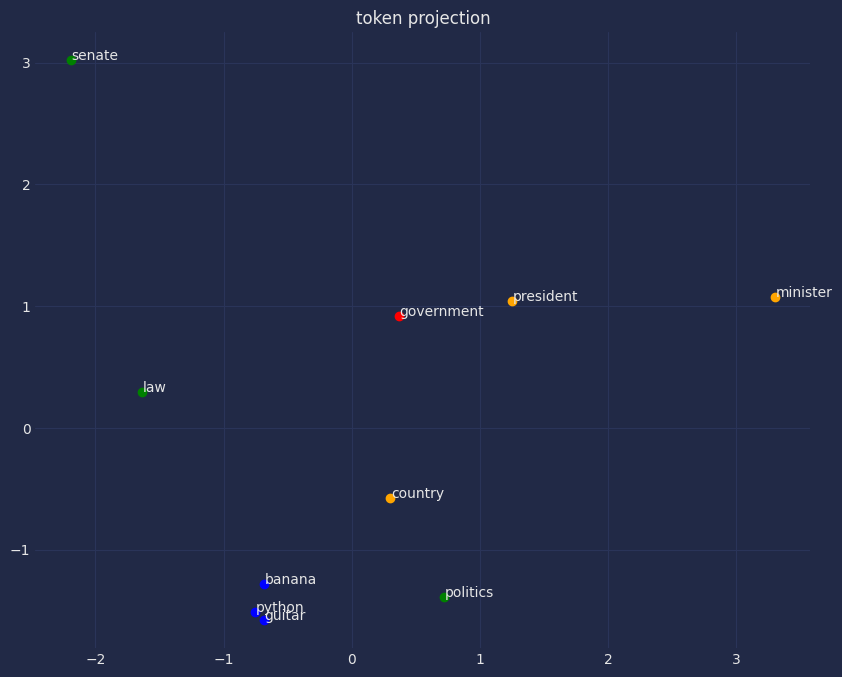

In [30]:
token_groups = {
    "base": ["government"],
    "similar": ["politics", "law", "senate"],
    "domain": ["country", "president", "minister"],
    "random": ["banana", "python", "guitar"]
}
visualize_tokens(model, token_groups)